In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2
import os
import warnings
from sklearn.metrics import confusion_matrix, classification_report
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, AdamW, Adadelta, Adagrad, Adamax, Adafactor, Nadam, Ftrl
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers

2023-07-07 08:47:04.621735: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 08:47:05.264225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 08:47:06.938146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set random seed for Python's built-in random module
random.seed(7777)

# Set random seed for NumPy
np.random.seed(7777)

# Set random seed for TensorFlow
tf.random.set_seed(7777)

In [3]:
train_dataset_path = '/home/ubuntu/Image/Split/train'
val_dataset_path = '/home/ubuntu/Image/Split/val'
test_dataset_path = '/home/ubuntu/Image/Split/test'

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                   horizontal_flip = True,
                                    fill_mode='nearest')

In [6]:
# Get the list of class names by excluding the .ipynb_checkpoints directory
class_names = [name for name in os.listdir(train_dataset_path) if name != '.ipynb_checkpoints']
class_names

['Parking Lot', 'Harbor', 'Container']

In [7]:
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   classes=class_names)

# Get the initial label mappings
labels = {value: key for key, value in train_generator.class_indices.items()}

Found 4687 images belonging to 3 classes.


In [8]:
val_generator = train_datagen.flow_from_directory(val_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   classes=class_names)

# Get the initial label mappings
labels = {value: key for key, value in train_generator.class_indices.items()}

Found 1562 images belonging to 3 classes.


In [9]:
test_generator = train_datagen.flow_from_directory(test_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                  classes=class_names)

# Get the initial label mappings
labels = {value: key for key, value in train_generator.class_indices.items()}

Found 1564 images belonging to 3 classes.


In [10]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Parking Lot
1 : Harbor
2 : Container


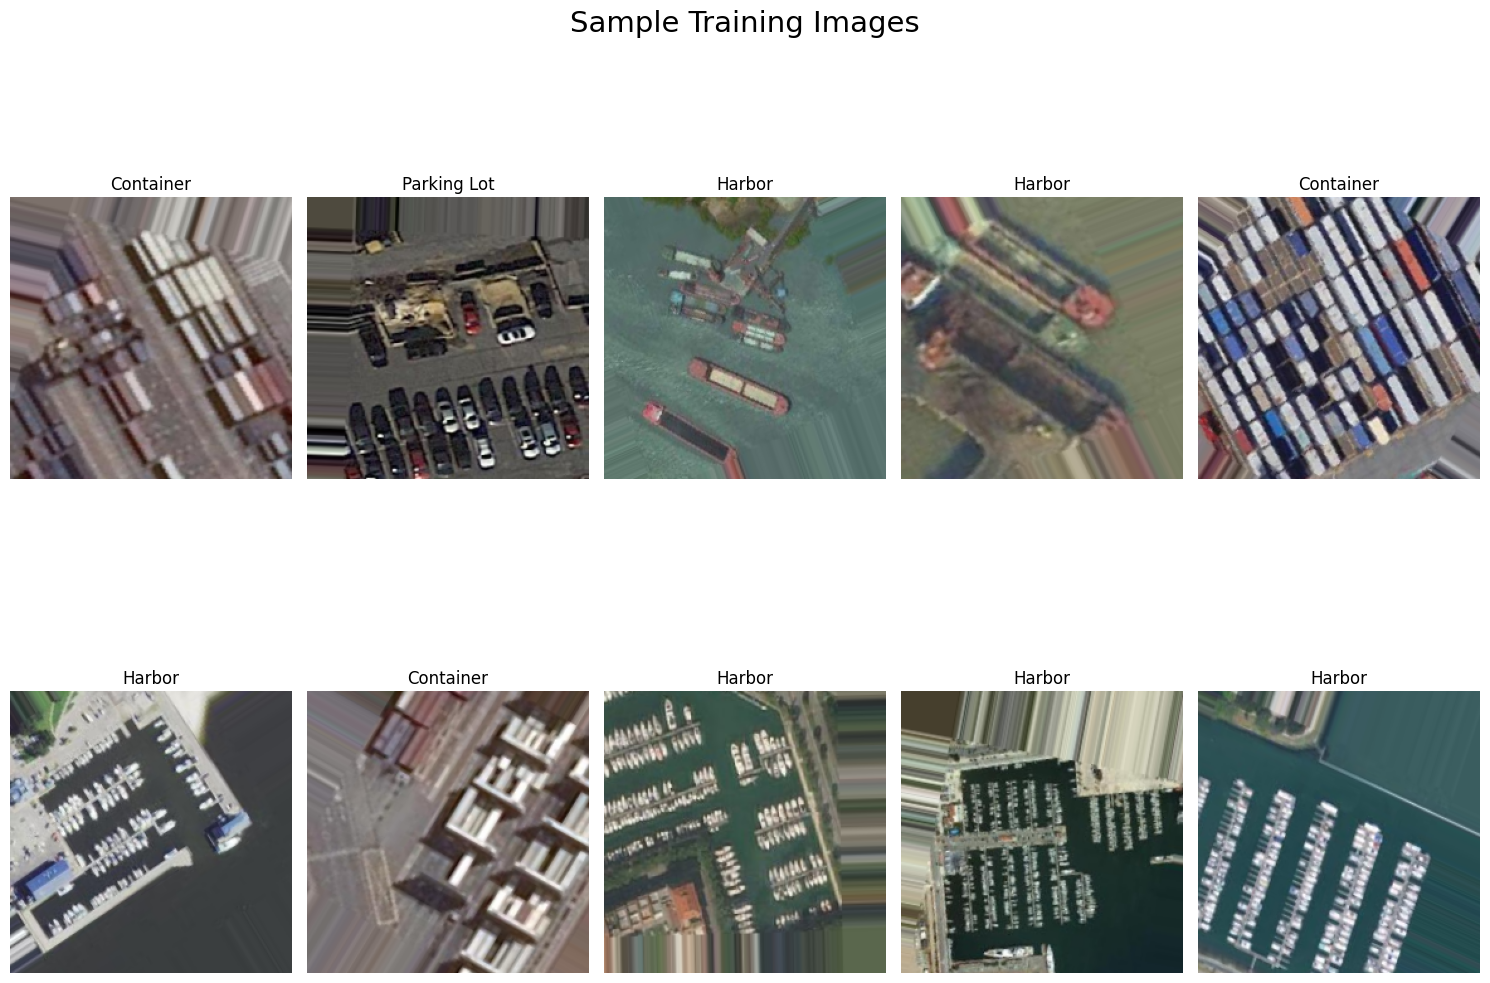

In [173]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


In [13]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=3, activation='softmax')
    ])
    
    return model

In [14]:
cnn_model = create_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 128)     9728      
                                                                 
 activation_3 (Activation)   (None, 220, 220, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 128)    0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 110, 110, 128)    512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 108, 108, 64)      73792     
                                                                 
 activation_4 (Activation)   (None, 108, 108, 64)     

In [155]:
optimizer = ['SGD', 'RMSprop', 'Adam', 'AdamW', 'Adadelta', 'Adagrad', 'Adamax', 'Adafactor', 'Nadam', 'Ftrl']

In [156]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, AdamW, Adadelta, Adagrad, Adamax, Adafactor, Nadam, Ftrl
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizers = ['SGD', 'RMSprop', 'Adam', 'AdamW', 'Adadelta', 'Adagrad', 'Adamax', 'Adafactor', 'Nadam', 'Ftrl']
learning_rate = 0.001
epochs = 1

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

for optimizer_name in optimizers:
    optimizer = globals()[optimizer_name](learning_rate=learning_rate)

    cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    history = cnn_model.fit(train_generator, epochs=epochs, validation_data=val_generator,
                            verbose=1, callbacks=[reduce_lr])
    
    # Retrieve and print the accuracy after training
    accuracy = history.history['val_accuracy'][-1]
    print(f"Optimizer: {optimizer_name} - Accuracy: {accuracy}")


2023-07-07 03:19:37.958880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8835

2023-07-07 03:20:28.461748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 67s 445ms/step - loss: 0.3518 - accuracy: 0.8835 - val_loss: 0.9647 - val_accuracy: 0.5512 - lr: 0.0010
Optimizer: SGD - Accuracy: 0.5512163639068604


2023-07-07 03:20:45.688260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 3.8523 - accuracy: 0.8088

2023-07-07 03:21:36.450044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 67s 440ms/step - loss: 3.8523 - accuracy: 0.8088 - val_loss: 6.4671 - val_accuracy: 0.4289 - lr: 0.0010
Optimizer: RMSprop - Accuracy: 0.42893725633621216


2023-07-07 03:21:52.969807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.8278 - accuracy: 0.8731

2023-07-07 03:22:43.954071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 67s 438ms/step - loss: 1.8278 - accuracy: 0.8731 - val_loss: 1.2662 - val_accuracy: 0.8079 - lr: 0.0010
Optimizer: Adam - Accuracy: 0.8079385161399841


2023-07-07 03:23:00.445378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.1467 - accuracy: 0.8905

2023-07-07 03:23:51.409440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 67s 438ms/step - loss: 1.1467 - accuracy: 0.8905 - val_loss: 6.2554 - val_accuracy: 0.7234 - lr: 0.0010
Optimizer: AdamW - Accuracy: 0.7234315276145935


2023-07-07 03:24:07.826964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.9110

2023-07-07 03:24:58.335535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 67s 437ms/step - loss: 0.6489 - accuracy: 0.9110 - val_loss: 0.5200 - val_accuracy: 0.9328 - lr: 0.0010
Optimizer: Adadelta - Accuracy: 0.9327784776687622


2023-07-07 03:25:14.967678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.9324

2023-07-07 03:26:04.845143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 66s 436ms/step - loss: 0.4485 - accuracy: 0.9324 - val_loss: 0.4856 - val_accuracy: 0.9411 - lr: 0.0010
Optimizer: Adagrad - Accuracy: 0.9411011338233948


2023-07-07 03:26:21.298020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.9396

2023-07-07 03:27:11.610987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 67s 436ms/step - loss: 0.4051 - accuracy: 0.9396 - val_loss: 0.4104 - val_accuracy: 0.9430 - lr: 0.0010
Optimizer: Adamax - Accuracy: 0.9430217742919922


2023-07-07 03:27:28.177314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9520

2023-07-07 03:28:20.943713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 69s 439ms/step - loss: 0.2504 - accuracy: 0.9520 - val_loss: 0.1588 - val_accuracy: 0.9738 - lr: 0.0010
Optimizer: Adafactor - Accuracy: 0.9737516045570374


2023-07-07 03:28:37.349145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.9085

2023-07-07 03:29:29.962443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 69s 443ms/step - loss: 0.6154 - accuracy: 0.9085 - val_loss: 0.4460 - val_accuracy: 0.9373 - lr: 0.0010
Optimizer: Nadam - Accuracy: 0.9372599124908447


2023-07-07 03:29:46.692972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.0924 - accuracy: 0.3348

2023-07-07 03:30:37.249870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 67s 437ms/step - loss: 1.0924 - accuracy: 0.3348 - val_loss: 1.0986 - val_accuracy: 0.3342 - lr: 0.0010
Optimizer: Ftrl - Accuracy: 0.33418694138526917


In [157]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, AdamW, Adadelta, Adagrad, Adamax, Adafactor, Nadam, Ftrl
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate = [0.1, 0.01, 0.001, 0.0001]
epochs = 1

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

for learning in learning_rate:
    optimizer = Adafactor(learning_rate=learning)

    cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    history = cnn_model.fit(train_generator, epochs=epochs, validation_data=val_generator,
                            verbose=1, callbacks=[reduce_lr])
    
    # Retrieve and print the accuracy after training
    accuracy = history.history['val_accuracy'][-1]
    print(f"learning_rate: {learning} - Accuracy: {accuracy}")


2023-07-07 03:32:33.739212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.3335

2023-07-07 03:33:25.596743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 68s 437ms/step - loss: 1.0988 - accuracy: 0.3335 - val_loss: 1.0986 - val_accuracy: 0.3342 - lr: 0.1000
learning_rate: 0.1 - Accuracy: 0.33418694138526917


2023-07-07 03:33:42.094789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3335

2023-07-07 03:34:34.175301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 68s 439ms/step - loss: 1.0986 - accuracy: 0.3335 - val_loss: 1.0986 - val_accuracy: 0.3342 - lr: 0.0100
learning_rate: 0.01 - Accuracy: 0.33418694138526917


2023-07-07 03:34:50.649623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3360

2023-07-07 03:35:43.681442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 69s 438ms/step - loss: 1.0986 - accuracy: 0.3360 - val_loss: 1.0986 - val_accuracy: 0.3342 - lr: 0.0010
learning_rate: 0.001 - Accuracy: 0.33418694138526917


2023-07-07 03:36:00.051018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3316

2023-07-07 03:36:51.960449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 68s 437ms/step - loss: 1.0986 - accuracy: 0.3316 - val_loss: 1.0986 - val_accuracy: 0.3342 - lr: 1.0000e-04
learning_rate: 0.0001 - Accuracy: 0.33418694138526917


In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adafactor(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
history = cnn_model.fit(train_generator, epochs=20, validation_data=val_generator,
                       verbose=1,
                       callbacks=[reduce_lr])

Epoch 1/20


2023-07-07 08:49:46.111867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-07 08:49:50.002113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-07 08:49:53.408087: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6e4800d350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-07 08:49:53.408118: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-07 08:49:53.488206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-07 08:49:54.179150: I ./tensor

147/147 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.7378

2023-07-07 08:50:47.918292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 79s 454ms/step - loss: 0.7371 - accuracy: 0.7378 - val_loss: 1.3305 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 2/20
147/147 [==============================] - 62s 420ms/step - loss: 0.3300 - accuracy: 0.8959 - val_loss: 1.4745 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 3/20
147/147 [==============================] - 62s 421ms/step - loss: 0.2320 - accuracy: 0.9285 - val_loss: 0.4069 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 4/20
147/147 [==============================] - 61s 417ms/step - loss: 0.2147 - accuracy: 0.9319 - val_loss: 0.3356 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 5/20
147/147 [==============================] - 61s 417ms/step - loss: 0.1858 - accuracy: 0.9426 - val_loss: 0.3128 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 6/20
147/147 [==============================] - 61s 418ms/step - loss: 0.1525 - accuracy: 0.9509 - val_loss: 0.1243 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 7/20
147/147 [==============================] - 62s 420ms

In [18]:
predictions = cnn_model.predict(test_generator)

2023-07-07 09:10:36.736438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 17s 345ms/step


In [19]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

2023-07-07 09:10:54.130466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 15s 313ms/step - loss: 0.0743 - accuracy: 0.9808


In [22]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.07425321638584137
Test Accuracy: 0.9808183908462524


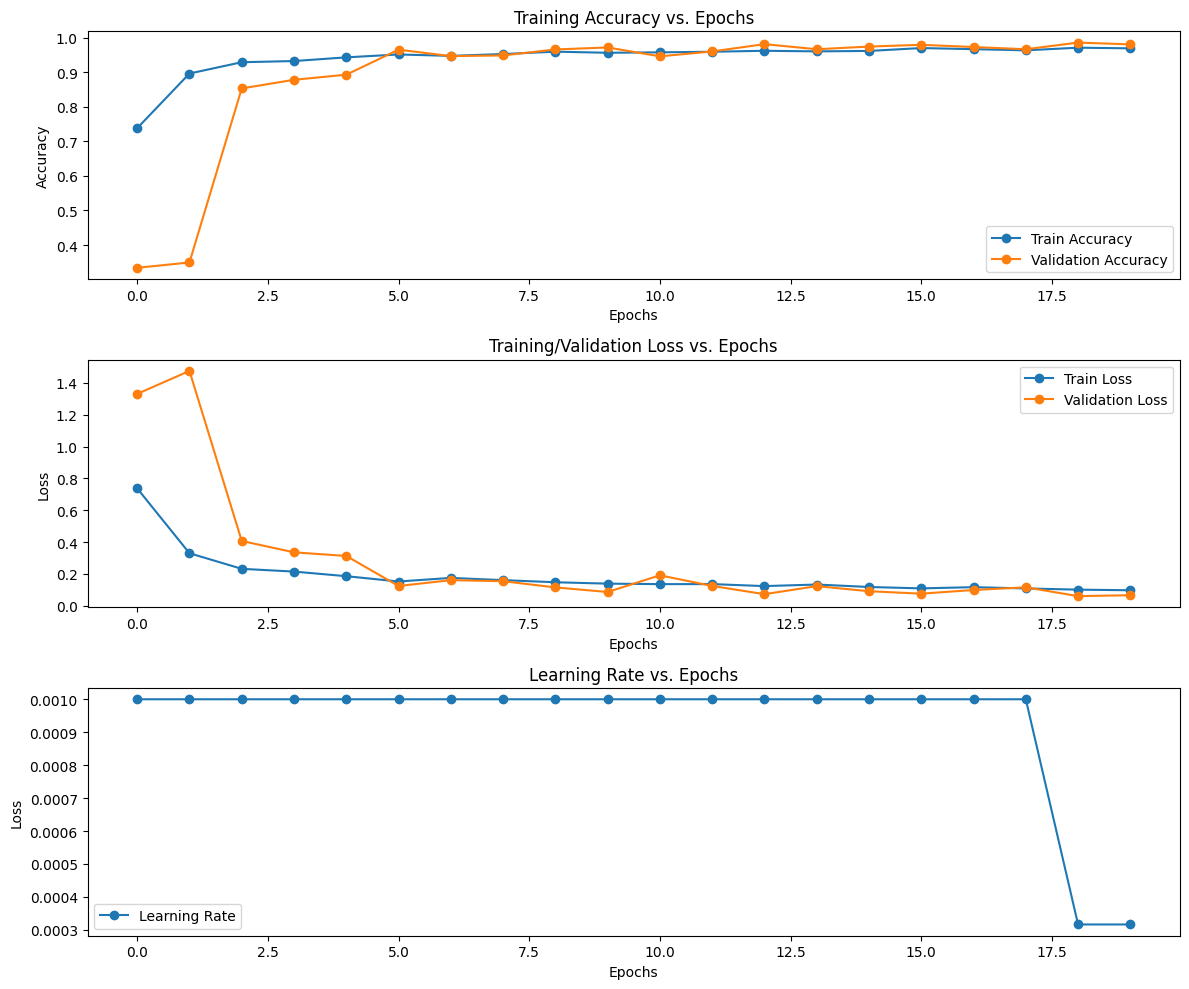

In [23]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [183]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

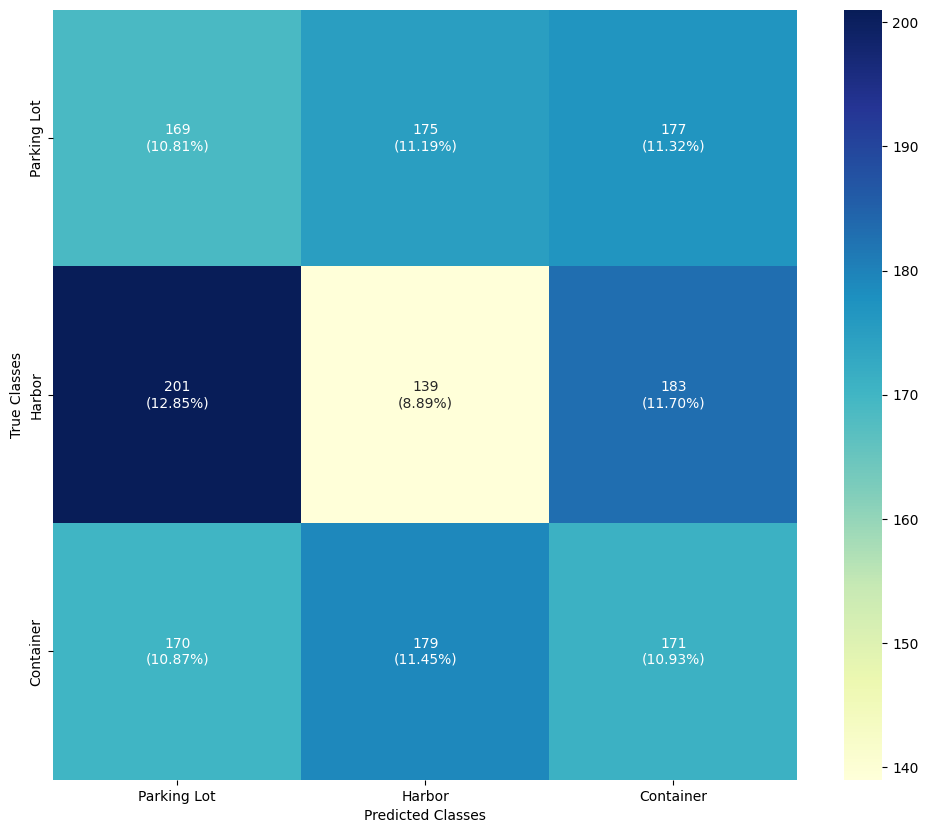

In [184]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(3, 3)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [185]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

 Parking Lot       0.31      0.32      0.32       521
      Harbor       0.28      0.27      0.27       523
   Container       0.32      0.33      0.33       520

    accuracy                           0.31      1564
   macro avg       0.31      0.31      0.31      1564
weighted avg       0.31      0.31      0.31      1564



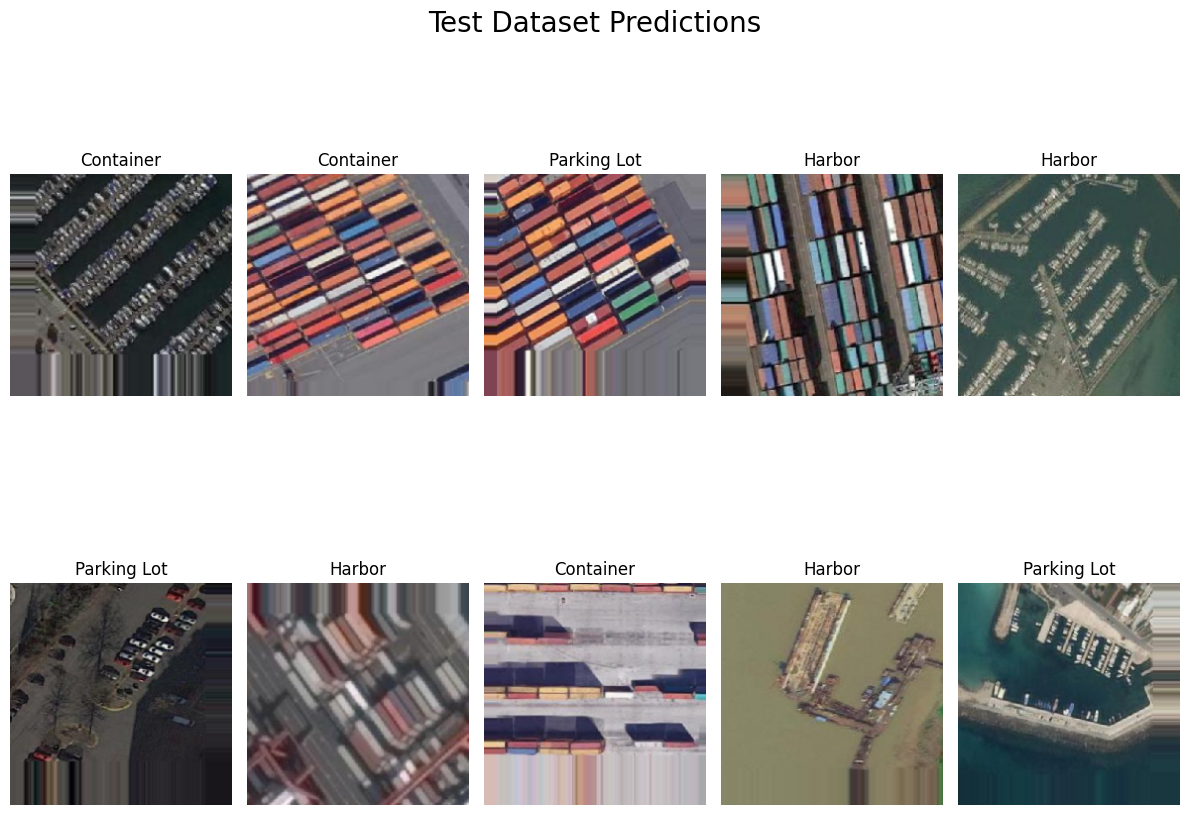

In [146]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


In [153]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [154]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]   

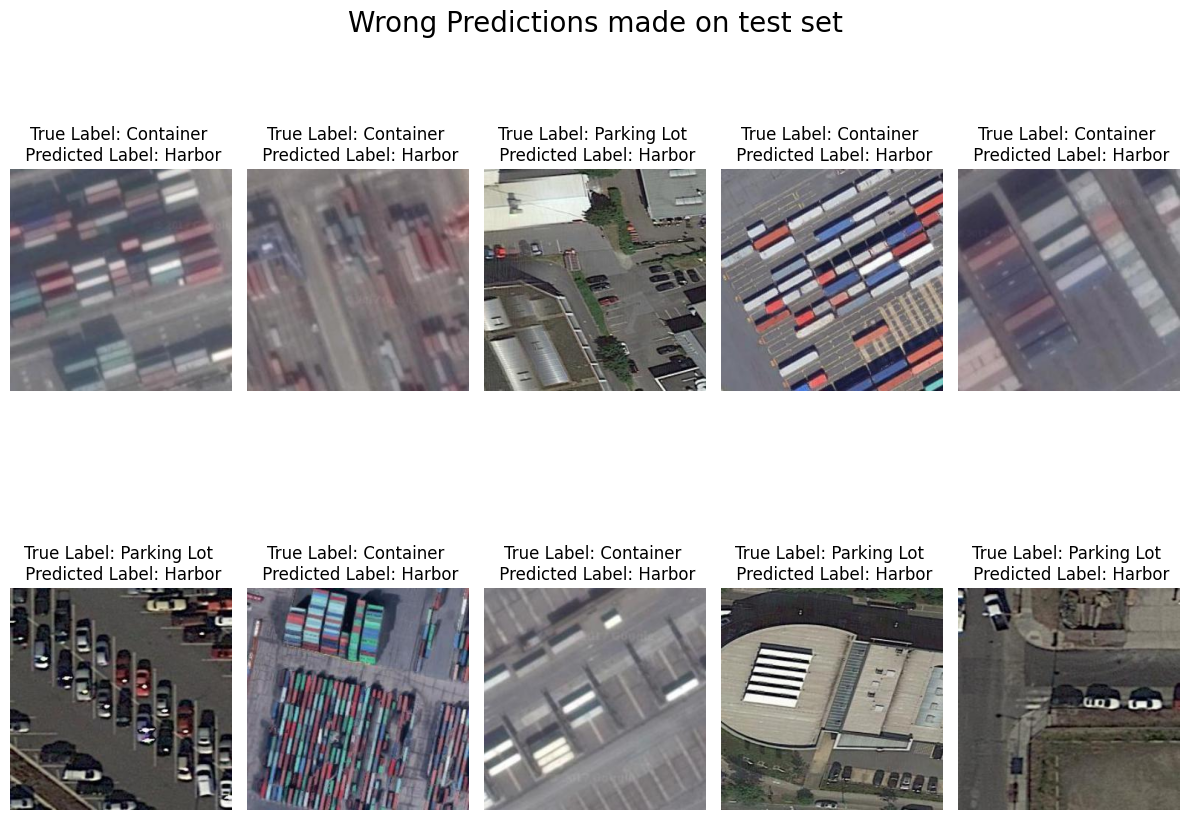

In [155]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()